In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sachinperimbeti","key":"0f02925d91b2dbedfd026269407cfeb2"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 71 Aug 22 18:52 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pwd

/content


In [ ]:
!kaggle competitions list

ref                                                                                     deadline             category                reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2024                                      2024-11-10 23:59:00  Featured         1,100,000 Usd        777           False  
https://www.kaggle.com/competitions/isic-2024-challenge                                 2024-09-06 23:59:00  Research            80,000 Usd       2405           False  
https://www.kaggle.com/competitions/rsna-2024-lumbar-spine-degenerative-classification  2024-10-08 23:59:00  Featured            50,000 Usd       1088           False  
https://www.kaggle.com/competitions/ariel-data-challenge-2024                           2024-10-31 23:59:00  Featured            50,000 Usd        311     

In [ ]:
!kaggle competitions download -c gan-getting-started

100% 366M/367M [00:20<00:00, 13.8MB/s]
100% 367M/367M [00:20<00:00, 18.4MB/s]


In [ ]:
!unzip gan-getting-started.zip

Streaming output truncated to the last 5000 lines.
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  inflating: photo_jpg/47d391d94b.jpg  
  inflating: photo_jpg/47df26

# **Monet GAN**

This project focuses on leveraging deep learning techniques to generate images in the style of the renowned artist Claude Monet using a CycleGAN (Cycle-Consistent Generative Adversarial Network) architecture. The central objective is to translate images from one domain (photographs) into another (Monet-style paintings) by training a model on datasets comprising real Monet images and real photographs. This project utilizes TensorFlow and Keras libraries for the implementation of the CycleGAN model, aiming to produce realistic Monet-style paintings from photographs while preserving the content and structure of the original images. By applying these methods, the project showcases the power of GANs in the domain of artistic style transfer.

In [ ]:
#import libraries
#general liraries
import numpy as np
#visualizations
import matplotlib.pyplot as plt

#model development
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import GroupNormalization
from tensorflow.keras.optimizers import Adam
#from kaggle_datasets import KaggleDatasets



**Loading the datasets**

In [ ]:
MONET_FILENAMES = tf.io.gfile.glob('/content/monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('/content/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


# **Exploratory Data Analysis (Includes Data Cleaning and Processing)**


The project begins with the loading and preprocessing of the datasets, which include Monet-style paintings and real photographs stored in TFRecord files. Each image in these datasets is an RGB image of size 256x256 pixels. The images are first loaded using TensorFlow's data pipeline, where the images are decoded, rescaled to a range of [-1, 1], and reshaped to the required dimensions. This preprocessing step is crucial as it standardizes the input data, ensuring that it is in the correct format for training the CycleGAN model. Functions such as decode_image and read_tfrecord are used to efficiently handle the TFRecord structure, and the datasets are then mapped and batched for easier processing during model training. An exploratory analysis includes visualizing some example images from both the Monet and photo datasets, which provides insights into the data characteristics and the stylistic differences between the two domains.

In [ ]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3) # 3 channels for RGB
    image = (tf.cast(image, tf.float32) / 127.5) - 1 # rescale each channel to [-1,1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

#function to parse a TFRecord file's structure. This is passed into the dataset.map function for decoding
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

#function to load the entire dataset from each TFRecord. Maps using the above TFRecord file structure
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

**Visualizing example images from both datasets**

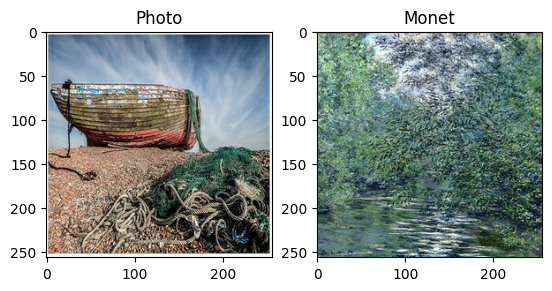

In [ ]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# **Model Building**

### **Generator**

This code defines the architecture of a generator model used in a CycleGAN, specifically designed to perform image-to-image translation. The generator network is constructed using a series of downsampling and upsampling blocks, and it leverages skip connections to combine information from different layers.



**Downsampling Block**: The function downsample creates a downsampling block that reduces the spatial dimensions of the input image while increasing the number of filters (feature maps). It consists of a 2D convolutional layer with a specified number of filters and kernel size, followed by instance normalization (if apply_instancenorm is true), and finally, a LeakyReLU activation function. The convolution uses a stride of 2, effectively halving the image size with each downsampling block.



In [ ]:
#creates a downsampling block
def downsample(filters, size, i, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02) #kernel weight initialization

    result = keras.Sequential(name=f'Downsample_{i}')
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tf.keras.layers.GroupNormalization(groups=-1)) #Applies an instance normalization

    result.add(layers.LeakyReLU())

    return result

**Upsampling Block**: The function upsample creates an upsampling block that increases the spatial dimensions of the image while reducing the number of filters. This is achieved through a 2D transposed convolutional layer (also known as a deconvolution or upsampling layer), followed by instance normalization, and optionally, a dropout layer (if apply_dropout is true). Finally, a ReLU activation function is applied. This block effectively doubles the image size with each upsampling operation.



In [ ]:
def upsample(filters, size, i, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential(name=f'Upsample_{i}')
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tf.keras.layers.GroupNormalization(groups=-1))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### **Generator Model**

The Generator function constructs the overall generator model by stacking a sequence of downsampling and upsampling blocks.


*   Downsampling: The model first applies a series of downsampling blocks, where each block reduces the image size by half while increasing the number of filters. The downsampled images are stored in the skips list to be used later in skip connections.
*   Upsampling: After downsampling, the model then applies a series of upsampling blocks. These blocks increase the image size by doubling it at each step. The model establishes skip connections by concatenating the corresponding downsampled feature maps (stored in skips) with the upsampled feature maps. This helps retain high-resolution details in the output image.
*   Final Layer: The model concludes with a final transposed convolutional layer with a tanh activation function. This layer produces the output image with the same dimensions as the input (256x256x3), ensuring that the generated image has pixel values in the range [-1, 1], which is typical for GANs.











In [ ]:
OUTPUT_CHANNELS = 3
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    #Set of downsample blocks, each downsample halves the image size due to stride=2
    # bs = batch size
    down_stack = [
        downsample(64, 4, 1, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4, 2), # (bs, 64, 64, 128)
        downsample(256, 4, 3), # (bs, 32, 32, 256)
        downsample(512, 4, 4), # (bs, 16, 16, 512)
        downsample(512, 4, 5), # (bs, 8, 8, 512)
        downsample(512, 4, 6), # (bs, 4, 4, 512)
        downsample(512, 4, 7), # (bs, 2, 2, 512)
        downsample(512, 4, 8), # (bs, 1, 1, 512)
    ]

    #Set of upsample blocks, each upsample doubles the image size due to stride=2.
    #The filter size should match its complimenting downsample for concatenation,
    #and should end with a (bs, 128, 128, filters) shape for the final tanh output layer
    up_stack = [
        upsample(512, 4, 7, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, 6, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, 5, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4, 4), # (bs, 16, 16, 1024)
        upsample(256, 4, 3), # (bs, 32, 32, 512)
        upsample(128, 4, 2), # (bs, 64, 64, 256)
        upsample(64, 4, 1), # (bs, 128, 128, 128)
    ]

    #Final upsampling, must be shaped (bs, 256, 256, 3)
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
        #print(x.shape[3])
        x = layers.Conv2D(x.shape[3], (3,3), strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False, activation=layers.LeakyReLU())(x)
        x = layers.Conv2D(x.shape[3], (3,3), strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False, activation=layers.LeakyReLU())(x)

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)


**Test and Summary:** The test_generator = Generator() line initializes the generator model, and test_generator.summary() prints a summary of the model's architecture, including the layers and their output shapes.

Overall, this generator model is designed to take an input image and transform it into a new image, following the architectural principles of a U-Net, which is common in image-to-image translation tasks like those performed by CycleGANs. The skip connections play a crucial role in preserving fine details, enabling the model to produce high-quality, detailed outputs.

In [ ]:
test_generator = Generator()
test_generator.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Downsample_1 (Sequential) │ (None, 128, 128, 64)   │          3,072 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Downsample_2 (Sequential) │ (None, 64, 64, 128)    │        131,328 │ Downsample_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Downsample_3 (Sequential) │ (None, 32, 32, 256)    │        524,800 │ Downsample_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Downsample_4 (Sequential) │ (None, 16, 16, 512)    │      2,098,176 │ Downsample_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Downsample_5 (Sequential) │ (None, 8, 8, 512)      │      4,195,328 │ Downsample_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Downsample_6 (Sequential) │ (None, 4, 4, 512)      │      4,195,328 │ Downsample_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Downsample_7 (Sequential) │ (None, 2, 2, 512)      │      4,195,328 │ Downsample_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Downsample_8 (Sequential) │ (None, 1, 1, 512)      │      4,195,328 │ Downsample_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Upsample_7 (Sequential)   │ (None, 2, 2, 512)      │      4,195,328 │ Downsample_8[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2, 2, 1024)     │              0 │ Upsample_7[0][0],      │
│                           │                        │                │ Downsample_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 2, 2, 1024)     │      9,437,184 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 2, 2, 1024)     │      9,437,184 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Upsample_6 (Sequential)   │ (None, 4, 4, 512)      │      8,389,632 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 4, 4, 1024)     │              0 │ Upsample_6[0][0],      │
│ (Concatenate)             │                        │                │ Downsample_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 4, 4, 1024)     │      9,437,184 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 4, 4, 1024)     │      9,437,184 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Upsample_5 (Sequential)   │ (None, 8, 8, 512)      │      8,389,632 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2        

 Total params: 136,105,603 (519.20 MB)

 Trainable params: 136,105,603 (519.20 MB)

 Non-trainable params: 0 (0.00 B)

### **Discriminator**

This code defines the architecture of a discriminator model, a key component of a Generative Adversarial Network (GAN), tasked with distinguishing between real and generated images. It begins by initializing the weights of the convolutional layers with a random normal distribution to stabilize training. The input layer accepts 256x256 RGB images. The model comprises three downsampling blocks that progressively reduce the image's spatial dimensions while increasing feature maps, capturing increasingly complex features. After downsampling, zero-padding is applied before a convolutional layer with 512 filters extracts deeper features. This is followed by instance normalization to stabilize activations and a LeakyReLU activation to introduce non-linearity. The final layers apply additional zero-padding and a convolution to produce a 30x30 output score map, with each value indicating the likelihood of a particular image patch being real or generated. The model uses a PatchGAN architecture, evaluating small patches of the image independently to focus on fine-grained details, making it an effective adversary in the GAN framework. The model is then instantiated and its architecture summarized.

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, 1, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4, 2)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4, 3)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tf.keras.layers.GroupNormalization(groups=-1)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
test_discriminator = Discriminator()
test_discriminator.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Downsample_1 (Sequential)            │ (None, 128, 128, 64)        │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Downsample_2 (Sequential)            │ (None, 64, 64, 128)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Downsample_3 (Sequential)            │ (None, 32, 32, 256)         │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 34, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 31, 31, 512)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_16               │ (None, 31, 31, 512)         │           1,024 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_25 (LeakyReLU)           │ (None, 31, 31, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_1 (ZeroPadding2D)     │ (None, 33, 33, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 30, 30, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,765,569 (10.55 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

# **The CycleGAN Class**

The CycleGan class, based on Amy Jang's tutorial, encapsulates the essential components of a CycleGAN model within the TensorFlow Keras framework. By inheriting from tf.keras.Model, this class leverages the built-in capabilities of Keras models, such as the ability to use fit, compile, and other utility functions. The CycleGAN model itself consists of two generators and two discriminators, designed for bidirectional transformation—specifically, converting photographs to Monet-style paintings and vice versa. In addition to these components, the model uses four distinct loss functions: discriminator loss, generator loss, cycle consistency loss, and identity loss. These losses work together to calculate the overall performance and accuracy of the model during training. The CycleGan class initializes the two generators and discriminators, assigns them their respective optimizers, and then compiles the model with all necessary components, including the loss functions. The train_step method performs the core training logic by calculating the various losses, computing gradients, and applying them to the model's parameters using the optimizers. Each optimizer utilizes the Adam algorithm with a learning rate of 0.0001 and a beta_1 parameter of 0.5, fine-tuned for the nuances of training GANs. The class architecture ensures that the model's bidirectional nature is preserved, promoting accurate and stable transformations between photographs and Monet-style paintings.

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### **Preparing the CycleGAN**

In [ ]:
monet_generator = Generator() # photograph -> Monet
photo_generator = Generator() # Monet -> photograph

monet_discriminator = Discriminator() # differentiates real and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real and generated photographs

monet_generator_optimizer = Adam(1e-4, beta_1=0.5)
photo_generator_optimizer = Adam(1e-4, beta_1=0.5)

monet_discriminator_optimizer = Adam(1e-4, beta_1=0.5)
photo_discriminator_optimizer = Adam(1e-4, beta_1=0.5)

### **Implementing the Loss Functions**

**Discriminator loss**

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

**Generator Loss**

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

**Cycle Loss**

In [ ]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

**Identity Loss**

In [ ]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

### **Building the CycleGAN**

Here we demonstrate the training and application of a CycleGAN model for image translation, specifically transforming photos into Monet-style paintings. It first instantiates a CycleGan object with pre-defined generators and discriminators, then compiles the model with specific optimizers and loss functions for generators and discriminators, as well as cycle-consistency and identity losses. The model is trained for 25 epochs using zipped datasets of Monet and photo images. A warning indicates potential issues with dataset size or configuration. After training, the Monet generator is saved, and a set of images is passed through it to generate Monet-style outputs. These results are displayed alongside the original photos to visualize the transformations. The visualization code properly reverses any preprocessing applied to the images to ensure accurate display.

In [ ]:
#instantiate the cycleGAN
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

#train the cycleGAN on the dataset
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25,
)

monet_generator.save("Monet_Generator.keras")

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 282s 504ms/step - monet_disc_loss: 0.6628 - monet_gen_loss: 5.9314 - photo_disc_loss: 0.6802 - photo_gen_loss: 5.9042
Epoch 2/25


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 151s 502ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 4.3569 - photo_disc_loss: 0.6574 - photo_gen_loss: 4.2052
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 151s 502ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 3.9946 - photo_disc_loss: 0.6414 - photo_gen_loss: 3.9052
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 151s 503ms/step - monet_disc_loss: 0.6266 - monet_gen_loss: 3.7873 - photo_disc_loss: 0.6279 - photo_gen_loss: 3.7601
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 202s 504ms/step - monet_disc_loss: 0.6405 - monet_gen_loss: 3.5941 - photo_disc_loss: 0.6229 - photo_gen_loss: 3.6292
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 202s 504ms/step - monet_disc_loss: 0.6357 - monet_gen_loss: 3.4969 - photo_disc_loss: 0.6096 - photo_gen_loss: 3.5839
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 151s 502ms/step - monet_disc_loss: 0.6277 - monet_gen_loss: 3.4518 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.5697
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 202s 504ms/step - monet

**Visualizing the Monet Generator**

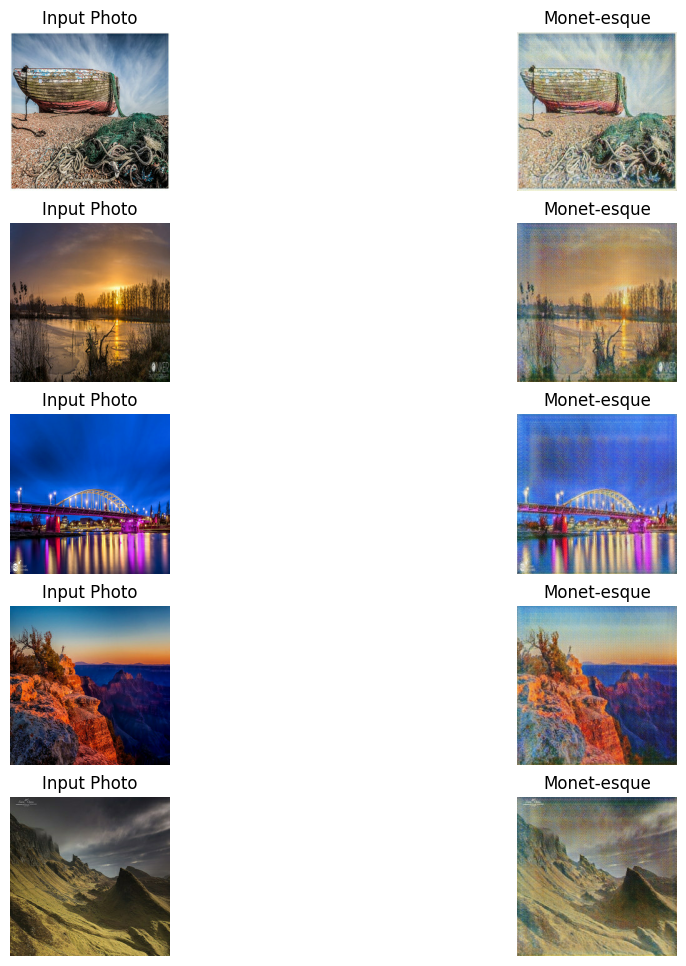

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Submission

In [ ]:
import PIL
! mkdir ../images

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")
